In [21]:
import json
from data.preprocess import DataProcessor
import os
from data.custom_dataset import CustomDataset
from data.utils import get_dataset, get_tokenizer, get_dataloader
from model.model import Model
import torch
import pandas as pd
import numpy as np
import torch.optim as optim
import ast
import os
import itertools
import torch.utils.checkpoint
from torch.cuda.amp import GradScaler, autocast
from training.trainer import Trainer
import argparse

def boolean_string(s):
    if s not in {'False', 'True'}:
        raise ValueError('Not a valid boolean string')
    return s == 'True'

import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')
# device
USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
cpu = torch.device('cpu')
print(device)

### for debugging use cpu
# device = cpu

config = {
#    "run_name": "Run_test_TLWAN"
    "run_name": "test"
    ,"project_path": '/vol/bitbucket/mh1022/temporal-modelling-icd'
    ,"base_checkpoint": os.path.join("", "RoBERTa-base-PM-M3-Voc-hf")
    ,"num_attention_heads": 1
    ,"num_layers": 0
    ,"lr": 5e-5
    ,"max_chunks":16
    ,"grad_accumulation": 16
    ,"use_positional_embeddings": True
    ,"use_reverse_positional_embeddings": True
    ,"priority_mode": "Last"
    ,"priority_idxs": [1]
    ,"use_document_embeddings": False
    ,"use_reverse_document_embeddings": False
    ,"use_category_embeddings": True
    ,"num_labels": 50
    ,"use_all_tokens": False
    ,"num_heads_labattn": 1
    ,"final_aggregation": "cls"
    ,"only_discharge_summary": False
    ,"patience_threshold": 3
    ,"max_epochs": 20
    ,"save_model": False
    ,"load_from_checkpoint": False
    ,"checkpoint_name": "Run_all_notes_last_second_transf"
    ,"evaluate_temporal": True
    ,"use_multihead_attention": True
    ,"debug": False
    ,"weight_aux": 0
    ,"setup": "random"
    ,"limit_ds": 0
    ,"is_baseline": False
    ,"aux_task": "none"
    ,"apply_transformation": False
    ,"apply_weight": False
    ,"reduce_computation": True
    ,"apply_temporal_loss": False

}
with open(os.path.join("", f"results/config_{config['run_name']}.json"), "w") as f:
    json.dump(config, f)

# process and aggregate raw data
dp = DataProcessor(dataset_path="dataset", config=config)
notes_agg_df, categories_mapping = dp.aggregate_data()

# get tokenizer
tokenizer = get_tokenizer(config["base_checkpoint"])

# Get training / validation / test
dataset_config = {
    "max_chunks" : config["max_chunks"],
    "setup" : config["setup"],
    "limit_ds" : config["limit_ds"],
}
training_set = get_dataset(notes_agg_df, "TRAIN", tokenizer = tokenizer, **dataset_config)
training_generator = get_dataloader(training_set)

validation_set =  get_dataset(notes_agg_df, "VALIDATION", tokenizer = tokenizer, **dataset_config)
validation_generator = get_dataloader(validation_set)

test_set = get_dataset(notes_agg_df, "TEST", tokenizer = tokenizer, **dataset_config)
test_generator = get_dataloader(test_set)

/vol/bitbucket/mh1022/dl_cw_pyenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


/vol/bitbucket/mh1022/temporal-modelling-icd/data/preprocess.py:16: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  self.notes_df = pd.read_csv(os.path.join(dataset_path, "NOTEEVENTS.csv"))


{'Nursing/other': 0, 'Radiology': 1, 'Nursing': 2, 'Physician ': 3, 'ECG': 4, 'Discharge summary': 5, 'Respiratory ': 6, 'Echo': 7, 'Nutrition': 8, 'General': 9, 'Rehab Services': 10, 'Social Work': 11, 'Case Management ': 12, 'Consult': 13, 'Pharmacy': 14}


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


#### 3.2 - Temporal distribution

All graphs will be done based off the training set.

In [7]:
# Get number of chunks in each time frame
from tqdm import tqdm
hours_elapsed_list = []
categories_list = []
seq_ids_list = []
note_ids_list =  []
note_hours_elapsed_list = []
for i in tqdm(range(len(training_set))):
    input_ids = training_set[i]["input_ids"]
    attention_mask = training_set[i]["attention_mask"]
    seq_ids = training_set[i]["seq_ids"]
    category_ids = training_set[i]["category_ids"]
    hours_elapsed = training_set[i]["hours_elapsed"]
    cutoffs = training_set[i]["cutoffs"]
    hours_elapsed_list.append(hours_elapsed.tolist())
    categories_list.append(category_ids.tolist())
    seq_ids_list.append(seq_ids.tolist())

    # get indices of first distinct seq ids
    seq_ids = seq_ids.tolist()
    note_ids = [0]
    for i in range(1, len(seq_ids)):
        if seq_ids[i] != seq_ids[i-1]:
            note_ids.append(i)
    note_ids_list.append(note_ids)
    # get hours elapsed for each note
    hours_elapsed = hours_elapsed.tolist()
    note_hours_elapsed = [hours_elapsed[i] for i in note_ids]
    note_hours_elapsed_list.append(note_hours_elapsed)


100%|██████████| 8066/8066 [50:19<00:00,  2.67it/s]  


In [8]:
# save results to json
results = {
    "hours_elapsed_list" : hours_elapsed_list,
    "categories_list" : categories_list,
    "seq_ids_list" : seq_ids_list,
    "note_ids_list" : note_ids_list,
    "note_hours_elapsed_list" : note_hours_elapsed_list
}
with open(os.path.join("", f"temporal_analysis_results.json"), "w") as f:
    json.dump(results, f)


### Make plots for section 3 of report

In [1]:
# load results from json
import json 
import os
results = json.load(open(os.path.join("", f"temporal_analysis_results.json"), "r"))
hours_elapsed_list = results["hours_elapsed_list"]
categories_list = results["categories_list"]
seq_ids_list = results["seq_ids_list"]
note_ids_list = results["note_ids_list"]
note_hours_elapsed_list = results["note_hours_elapsed_list"]


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
def set_size(width, fraction=0.8):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim




Plot number of notes in each time frame (x-axis: days, y-axis: number of notes)

79.3429444444445


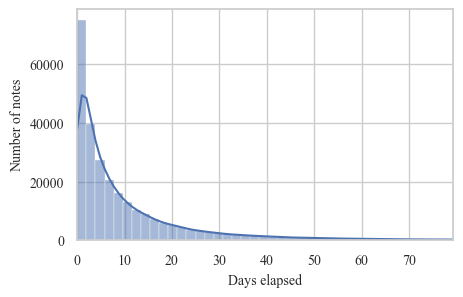

In [17]:
# plot the distribution of number of notes versus hours elapsed
# x-axis: days elapsed
# y-axis: total number of notes in that time range
sns.set_theme(style="whitegrid")
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 30

plt.figure(figsize=set_size(438.17227, fraction=0.8))
# hist plot of days elapsed
# convert hours elapsed to days elapsed
note_days_elapsed_list = []
note_percent_elapsed_list = []
for x in note_hours_elapsed_list:
    days = [i/24 for i in x]
    percent = [day/days[-1] if days[-1] != 0 else 0 for day in days]
    note_days_elapsed_list.extend([i/24 for i in x])
    note_percent_elapsed_list.extend(percent)

# find day of 99-th percentile
print(np.percentile(note_days_elapsed_list, 99))
sns.histplot(data=note_days_elapsed_list, bins=100,kde=True)
plt.xlabel("Days elapsed", fontsize=10)
plt.ylabel("Number of notes",fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# limit x-axis to 50 days
plt.xlim(0,79.34)
plt.savefig("figures/3_2_number_of_notes.png", bbox_inches = "tight", dpi=300)
plt.show()


Plot number of notes at each percentage of length of stay

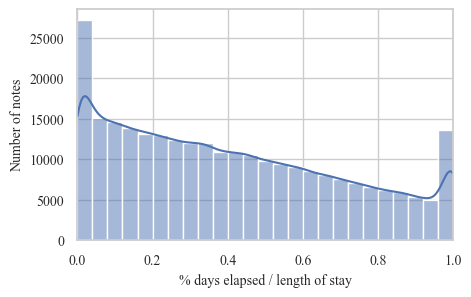

In [23]:
plt.figure(figsize=set_size(438.17227, fraction=0.8))

sns.histplot(data=note_percent_elapsed_list, bins=25,kde=True)
plt.xlabel("% days elapsed / length of stay", fontsize=10)
plt.ylabel("Number of notes",fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# limit x-axis to 50 days
plt.xlim(0,1)
plt.savefig("figures/3_2_notes_percent_stay.png", bbox_inches = "tight", dpi=300)
plt.show()

In [7]:
# show average number of non- discharge summary notes per patient
# show mean, median, q1, q3, max, min of DS notes per patient
print(f"median DS: {np.median([x.count(5) for x in categories_list])}")
print(f"mean DS: {np.mean([x.count(5) for x in categories_list])}")
print(f"q1 DS: {np.percentile([x.count(5) for x in categories_list], 25)}")
print(f"q3 DS: {np.percentile([x.count(5) for x in categories_list], 75)}")
print(f"max DS: {np.max([x.count(5) for x in categories_list])}")
print(f"min DS: {np.min([x.count(5) for x in categories_list])}")
# now for non-DS notes
print(f"median non-DS: {np.median([len(x) - x.count(5) for x in categories_list])}")
print(f"mean non-DS: {np.mean([len(x) - x.count(5) for x in categories_list])}")
print(f"q1 non-DS: {np.percentile([len(x) - x.count(5) for x in categories_list], 25)}")
print(f"q3 non-DS: {np.percentile([len(x) - x.count(5) for x in categories_list], 75)}")
print(f"max non-DS: {np.max([len(x) - x.count(5) for x in categories_list])}")
print(f"min non-DS: {np.min([len(x) - x.count(5) for x in categories_list])}")
#print all of these numbers in a string separated by & for latex table
non_ds_latex_string = f"{np.median([len(x) - x.count(5) for x in categories_list])} & {np.mean([len(x) - x.count(5) for x in categories_list])} & {np.percentile([len(x) - x.count(5) for x in categories_list], 25)} & {np.percentile([len(x) - x.count(5) for x in categories_list], 75)} & {np.max([len(x) - x.count(5) for x in categories_list])} & {np.min([len(x) - x.count(5) for x in categories_list])}"
print(non_ds_latex_string)
# now all
print(f"median all: {np.median([len(x) for x in categories_list])}")
print(f"mean all: {np.mean([len(x) for x in categories_list])}")
print(f"q1 all: {np.percentile([len(x) for x in categories_list], 25)}")
print(f"q3 all: {np.percentile([len(x) for x in categories_list], 75)}")
# print 99th percentile
print(f"90th percentile all: {np.percentile([len(x) for x in categories_list], 90)}")
print(f"95th percentile all: {np.percentile([len(x) for x in categories_list], 95)}")

print(f"max all: {np.max([len(x) for x in categories_list])}")
print(f"min all: {np.min([len(x) for x in categories_list])}")
#print all of these numbers in a string separated by & for latex table
all_ds_latex_string = f"{np.median([len(x) for x in categories_list])} & {np.mean([len(x) for x in categories_list])} & {np.percentile([len(x) for x in categories_list], 25)} & {np.percentile([len(x) for x in categories_list], 75)} & {np.max([len(x) for x in categories_list])} & {np.min([len(x) for x in categories_list])}"
print(all_ds_latex_string)


median DS: 6.0
mean DS: 6.814530126456732
q1 DS: 4.0
q3 DS: 8.0
max DS: 31
min DS: 1
median non-DS: 19.0
mean non-DS: 49.011653855690554
q1 non-DS: 10.0
q3 non-DS: 47.0
max non-DS: 2949
min non-DS: 0
19.0 & 49.011653855690554 & 10.0 & 47.0 & 2949 & 0
median all: 27.0
mean all: 55.826183982147285
q1 all: 16.0
q3 all: 55.0
90th percentile all: 114.0
95th percentile all: 181.0
max all: 2967
min all: 1
27.0 & 55.826183982147285 & 16.0 & 55.0 & 2967 & 1


In [8]:
2967*512

1519104

Box-plots of number of notes of each type per patient

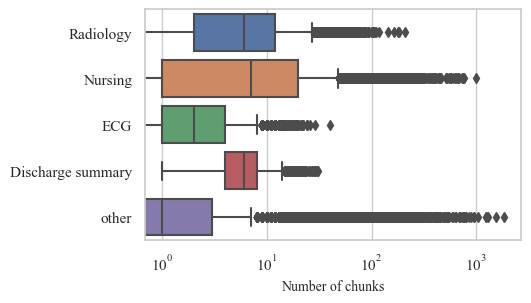

In [53]:
# boxplot of number of notes of eachacategory per patient
# x-axis: category
# y-axis: number of notes (boxplot)
import pandas as pd
categories_to_num = {'Nursing/other': 0, 'Radiology': 1, 'Nursing': 2, 'Physician ': 3, 'ECG': 4, 'Discharge summary': 5, 'Respiratory ': 6, 'Echo': 7, 'Nutrition': 8, 'General': 9, 'Rehab Services': 10, 'Social Work': 11, 'Case Management ': 12, 'Consult': 13, 'Pharmacy': 14}
num_to_categories = {v: k for k, v in categories_to_num.items()}
notes_per_category = {cat: [] for cat in num_to_categories.keys()}
for i in range(len(categories_list)):
    for cat in num_to_categories.keys():
        notes_per_category[cat].append(categories_list[i].count(cat))

# group categroies 0, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14 as "other"
notes_per_category[15] = [sum([notes_per_category[i][j] for i in [0, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14]]) for j in range(len(notes_per_category[0]))]
categories_to_num["other"] = 15
num_to_categories[15] = "other"
for i in [0, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14]:
    del notes_per_category[i]
    del categories_to_num[num_to_categories[i]]

    del num_to_categories[i]

# show boxplot 

plt.figure(figsize=set_size(438.17227, fraction=0.8))
sns.boxplot(data=pd.DataFrame.from_dict(notes_per_category), orient="h")
plt.xlabel("Number of chunks", fontsize=10)
plt.ylabel("Category",fontsize=10)
# show category names as y-ticks
plt.yticks(range(len(num_to_categories.keys())), num_to_categories.values())
# limit x-axis to 100
# show x-axis in log scale
plt.xscale("log")
# remove y-label
plt.ylabel("")
plt.savefig("figures/3_2_notes_per_category.png", bbox_inches = "tight", dpi=300)
plt.show()

In [38]:
# show average number of notes per category
for cat in num_to_categories.keys():
    print(f"{cat}: {np.median(notes_per_category[cat])}")


0: 0.0
1: 6.0
2: 7.0
3: 0.0
4: 2.0
5: 6.0
6: 0.0
7: 0.0
8: 0.0
9: 0.0
10: 0.0
11: 0.0
12: 0.0
13: 0.0
14: 0.0


Plot length of stay distribution (x-axis: days, y-axis: length of stay)

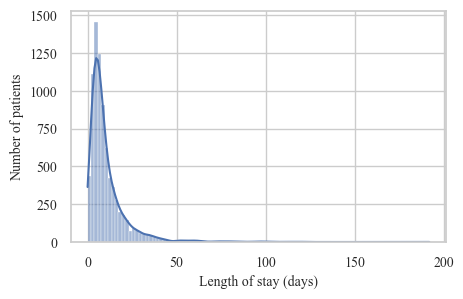

In [20]:
# plot length of stay distribution, x-axis: days elapsed, y-axis: number of patients
# get length of stay for each patient

length_of_stay_list = [hours_elapsed[-1]/24 for hours_elapsed in hours_elapsed_list]
plt.figure(figsize=set_size(438.17227))

sns.histplot(data=length_of_stay_list, bins=100, kde=True)

plt.xlabel("Length of stay (days)", fontsize=10)
plt.ylabel("Number of patients",fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig("figures/3_2_length_of_stay.png", bbox_inches = "tight", dpi=300)

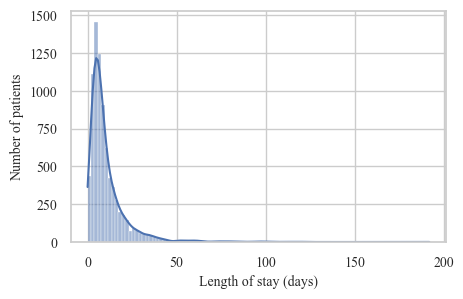

In [19]:
# plot length of stay distribution, x-axis: days elapsed, y-axis: number of patients
# get length of stay for each patient

length_of_stay_list = [hours_elapsed[-1]/24 for hours_elapsed in hours_elapsed_list]
plt.figure(figsize=set_size(438.17227, fraction=0.8))

sns.histplot(data=length_of_stay_list, bins=100, kde=True)

plt.xlabel("Length of stay (days)", fontsize=10)
plt.ylabel("Number of patients",fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig("figures/3_2_length_of_stay.png", bbox_inches = "tight",dpi=300)

Average length of stay: 10.659334449128027
Median length of stay: 7.0


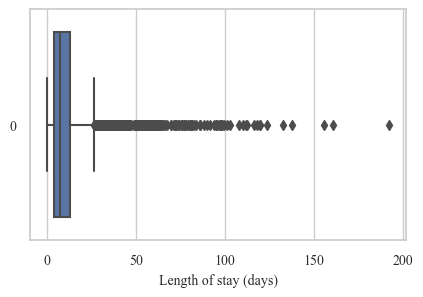

In [18]:
# get average, boxplot of length of stay
print(f"Average length of stay: {np.mean(length_of_stay_list)}")
print(f"Median length of stay: {np.median(length_of_stay_list)}")
# set figure size to 10x10
plt.figure(figsize=set_size(438.17227, fraction=0.8))
# show box plot horizontally
sns.boxplot(data=length_of_stay_list, orient="h")
plt.xlabel("Length of stay (days)", fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.savefig("figures/3_2_length_of_stay_boxplot.png", bbox_inches = "tight", dpi=300)

3.3 - Show percentieles on number of CHUNKS in training set (x-axis: percentile, y-axis: days)

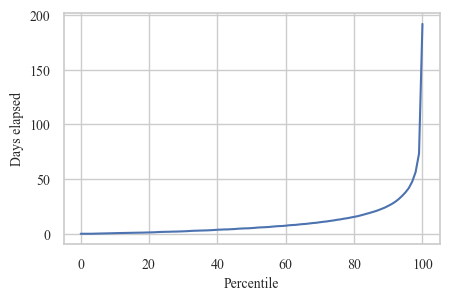

In [17]:
# show percentile plot of total number of chunks in training set
# i.e. number of days such that 25% of chunks are in that time range, etc..
# x-axis: percentile: 0-100
# y-axis: days elapsed
# get total number of chunks in each time range
plt.figure(figsize=set_size(438.17227, fraction=0.8))
note_days_elapsed = []
for hours_elapsed in hours_elapsed_list:
    note_days_elapsed.extend([hour/24.0 for hour in hours_elapsed])
# get percentile of total number of chunks
percentile_list = [np.percentile(note_days_elapsed, i) for i in range(0, 101)]
sns.lineplot(x=range(0, 101), y=percentile_list)
# highlight 25th, 50th, 75th percentile
# the line should be a half line stopping at the percentile
# plt.plot((0, 25), (percentile_list[25], percentile_list[25]), 'r-',linewidth=1)
# plt.plot((0, 50), (percentile_list[50], percentile_list[50]), 'r-',linewidth=1)

# plt.plot((0, 75), (percentile_list[75], percentile_list[75]), 'r-',linewidth=1)

# plt.axhline(y=percentile_list[25], color='r', linestyle='-', xmin=0, xmax=25)
# plt.axhline(y=percentile_list[50], color='r', linestyle='-', xmax=50)
# plt.axhline(y=percentile_list[75], color='r', linestyle='-', xmax=75)

# # draw an x marker at the 25th, 50th, 75th percentile
# plt.plot([25], [percentile_list[25]], marker='x', markersize=3, color="red")
# plt.plot([50], [percentile_list[50]], marker='x', markersize=3, color="red")
# plt.plot([75], [percentile_list[75]], marker='x', markersize=3, color="red")

# # show the 25th, 50th, 75th percentile
# # position text lower than the line
# plt.text(25, percentile_list[25]-10, f"{percentile_list[25]:.2f}", color="red", fontsize=10)
# plt.text(50, percentile_list[50]-10, f"{percentile_list[50]:.2f}", color="red", fontsize=10)
# plt.text(75, percentile_list[75]-10, f"{percentile_list[75]:.2f}", color="red", fontsize=10)

plt.xlabel("Percentile", fontsize=10)
plt.ylabel("Days elapsed",fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig("figures/3_3_percentiles.png", bbox_inches = "tight", dpi=300)
plt.show()


In [17]:
quantiles = [np.percentile(note_days_elapsed, i) for i in [25, 50, 75]]
print(quantiles)


[1.7874999999999999, 5.190972222222222, 12.763888888888888]


Text(0.5, 1.0, 'Distribution of chunks in hours elapsed')

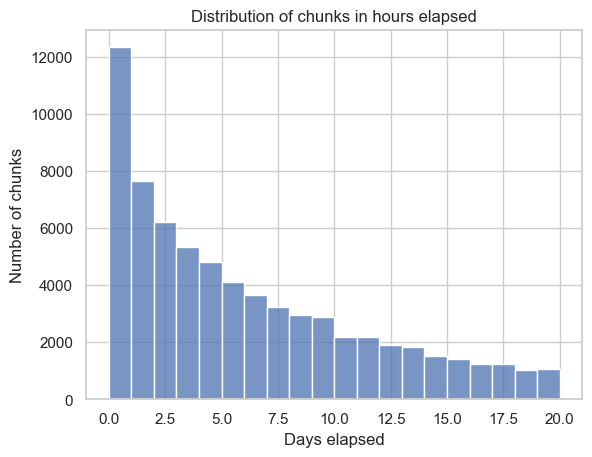

In [24]:
# print distribution of chunks in hours elapsed
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
# plot number of chunks in time buckets of 12 hours
# limit range to 0-24*20 hours
hours_elapsed_list_filt = [np.array(x)/24 for x in hours_elapsed_list]
hours_elapsed_list_filt = [x[x<20] for x in hours_elapsed_list_filt]
sns.histplot(np.concatenate(hours_elapsed_list_filt), bins = 20)
plt.xlabel("Days elapsed")
plt.ylabel("Number of chunks")
plt.title("Distribution of chunks in hours elapsed")


Try new experiment set up: select always first and last note, randomly sample in between

In [104]:
np.random.seed(1)
def filter_mask(seq_ids):
    first_note = seq_ids[0]
    first_indices = np.where(np.array(seq_ids) == seq_ids[0])[0]
    # limit DS to 4 chunks
    last_indices = np.where(np.array(seq_ids) == seq_ids[-1])[0][-4:]
    middle_indices = np.where(np.logical_and(np.array(seq_ids) > seq_ids[0], np.array(seq_ids) <  seq_ids[-1]))[0]
    middle_indices = np.sort(
        np.random.choice(
            middle_indices,
            max(0,min(len(middle_indices), 8 - len(first_indices) - len(last_indices))),
            replace = False
        )
    )
    return first_indices.tolist() +  middle_indices.tolist() + last_indices.tolist()

In [106]:
filter_mask(seq_ids_list[3])

[0, 55, 101, 122, 158, 159, 160, 161]

In [124]:
print(notes_agg_df.iloc[4]["CATEGORY"][-3])


Radiology


In [25]:
# TODO: I found that for some patients the DS is not the last note
# TODO: moreover, sometimes there are 2 DS, and the last one is void
print(notes_agg_df.iloc[6]["TEXT"][-1])
print(notes_agg_df.iloc[4]["ICD9_CODE_BINARY"])

Admission Date:  [**2186-11-21**]              Discharge Date:   [**2186-11-28**]


Service: CARDIOTHORACIC

Allergies:
Patient recorded as having No Known Allergies to Drugs

Attending:[**First Name3 (LF) 1283**]
Chief Complaint:
Fatigue and dyspnea on exertion

Major Surgical or Invasive Procedure:
[**2186-11-21**] - AVR 25mm St. [**Male First Name (un) 923**] Porcine Valve


History of Present Illness:
Splendid 80 year old gentleman who has severe aortic stenosis.
He sustained and inferior wall MI on [**2-/2178**] followed by a PTCA. He
recently had a colonic tumor/polyp removed in [**Month (only) 216**] and
developed chest pain as well as dyspnea perioperatively. A
cardiac catheterization was performed which revealed sever
aortic stenosis and no flow limiting disease. His ejection
fraction was preserved.

Past Medical History:
S/P Colonic polyp removal [**8-25**]
Left TKR [**2178**]
PTCA [**2178**]
IMI [**2178**]
HTN
AS
Hyperlipidemia
COPD
CRI
Depression
Erectile dysfunction

Socia

In [67]:
diagnosis = """Aortic Stenosis
Hyperlipidemia
PAF
HTN
COPD
IMI
PTCA [**2178**]
Postop confusion
Left TKR
Colonic polyp removal
CRI
Depression
Erectile Dysfunction""".split("\n")

diagnosis.append("polyp")
diagnosis.append("postop")
diagnosis.append("pulmonary")
diagnosis.append("angioplasty")

for i, note in enumerate(notes_agg_df.iloc[6]["TEXT"]):
    for diag in diagnosis:
        if diag.lower() in note.lower():
            print(i, diag, note.lower().find(diag.lower()))


0 Aortic Stenosis 177
0 CRI 1389
0 postop 143
0 pulmonary 950
3 IMI 443
4 Aortic Stenosis 173
4 postop 938
4 pulmonary 1032
6 Aortic Stenosis 180
7 Aortic Stenosis 455
7 Hyperlipidemia 938
7 PAF 4792
7 HTN 931
7 COPD 953
7 IMI 766
7 PTCA [**2178**] 900
7 Postop confusion 4825
7 Left TKR 880
7 Colonic polyp removal 847
7 CRI 958
7 Depression 962
7 Erectile Dysfunction 973
7 polyp 575
7 postop 2711


In [66]:
# TODO: I found that for some patients the DS is not the last note
# TODO: moreover, sometimes there are 2 DS, and the last one is void
INDEX=0
print(notes_agg_df.iloc[6]["TEXT"][INDEX][:])
print(notes_agg_df.iloc[6]["CATEGORY"][INDEX])



[**2186-11-21**] 11:38 AM
 CHEST PORT. LINE PLACEMENT                                      Clip # [**Clip Number (Radiology) 62117**]
 Reason: postop film
 Admitting Diagnosis: AORTIC STENOSIS\AORTIC VALVE REPLACEMENT/SDA
 ______________________________________________________________________________
 [**Hospital 2**] MEDICAL CONDITION:
  80 year old man s/p AVR
 REASON FOR THIS EXAMINATION:
  postop film
 ______________________________________________________________________________
                                 FINAL REPORT
 HISTORY:  80-year-old man status post AVR.  Please assess position of tubes
 and lines.

 TECHNIQUE:  A single AP supine portable chest radiograph was obtained.

 COMPARISON:  PA and lateral views of the chest [**2186-10-23**].

 FINDINGS:  There is an endotracheal tube in appropriate position with the tip
 approximately 3.5 cm above the carina.  There is a right IJ Swan-Ganz catheter
 with tip within the main pulmonary artery.  There is a mediastinal drain
 o

In [138]:
notes_agg_df_filt = notes_agg_df.copy()
# Modify the TEXT, CHARTDATE, CHARTTIME, CATEGORY columns
# by limiting the list to include all elements until the first DS
# the apply function is used to apply the lambda function to each row
# and it should filter based on the CATEGORY column
notes_agg_df_filt["TEXT"] = notes_agg_df_filt[["TEXT", "CATEGORY"]].apply(
    lambda x: x.TEXT[:x.CATEGORY.index("Discharge summary")+1],
    axis = 1
)
notes_agg_df_filt["CHARTDATE"] = notes_agg_df_filt[["CHARTDATE", "CATEGORY"]].apply(
    lambda x: x.CHARTDATE[:x.CATEGORY.index("Discharge summary")+1],
    axis = 1
)
notes_agg_df_filt["CHARTTIME"] = notes_agg_df_filt[["CHARTTIME", "CATEGORY"]].apply(
    lambda x: x.CHARTTIME[:x.CATEGORY.index("Discharge summary")+1],
    axis = 1
)
notes_agg_df_filt["CATEGORY"] = notes_agg_df_filt["CATEGORY"].apply(
    lambda x: x[:x.index("Discharge summary")+1]
)


In [ ]:
# TODO: investigate if the notes that are not DS are important

In [139]:
num = 0
for i in range(len(notes_agg_df)):
    if notes_agg_df.iloc[i]["CATEGORY"][-1] != "Discharge summary":
        num += 1
print(num)

1405


In [140]:
num = 0
for i in range(len(notes_agg_df_filt)):
    if notes_agg_df_filt.iloc[i]["CATEGORY"][-1] != "Discharge summary":
        num += 1
print(num)

0


In [115]:
notes_agg_df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'TEXT', 'CHARTDATE', 'CHARTTIME', 'CATEGORY',
       'SPLIT_50', 'absolute_code', 'CATEGORY_INDEX', 'CATEGORY_REVERSE_SEQID',
       'ADMISSION_DATETIME', 'TIME_ELAPSED', 'PERCENT_ELAPSED',
       'HOURS_ELAPSED', 'ICD9_CODE_BINARY', 'SPLIT'],
      dtype='object')

In [116]:
print(notes_agg_df.iloc[3]["absolute_code"])

['608.83', '038.9', '995.92', '584.9', '428.0', '427.31', '998.2', '997.4', '560.1', '608.4', 'E870.8', '414.00', 'V45.81', '62.3', '31.1', '61.3', '43.19', '96.6', '96.72', '33.23', '38.93']


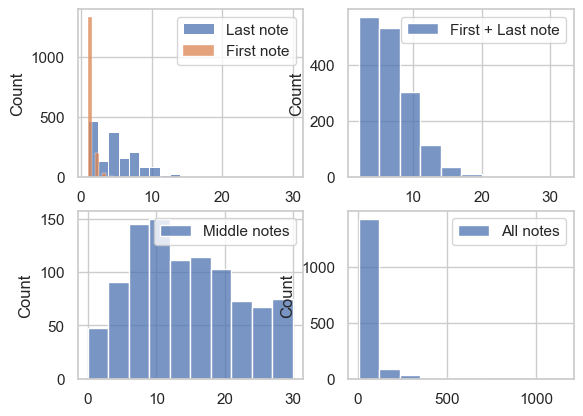

In [86]:
plt.subplot(2,2,1)
# print distribution of number of chunks of last note
sns.histplot([np.sum(np.array(seq_ids) == seq_ids[-1]) for seq_ids in seq_ids_list], bins = 20, label = "Last note")
# print distribution of number of chunks of first note
sns.histplot([np.sum(np.array(seq_ids) == seq_ids[0]) for seq_ids in seq_ids_list], bins = 20, label = "First note")
# print distribution of the sum of number of chunks of last and first note
plt.legend()
plt.subplot(2,2,2)
sns.histplot([np.sum(np.array(seq_ids) == seq_ids[0]) + np.sum(np.array(seq_ids) == seq_ids[-1]) for seq_ids in seq_ids_list], bins = 10, label = "First + Last note")
plt.legend()
plt.subplot(2,2,3)
# print distribution of number of chunks that are not first or last note
sns.histplot([np.sum(np.logical_and(np.array(seq_ids) > seq_ids[0], np.array(seq_ids) < seq_ids[-1]) )for seq_ids in seq_ids_list], bins = 10, label = "Middle notes", binrange=(0, 30))
plt.legend()
plt.subplot(2,2,4)
# print distribution of ALL notes
sns.histplot([len(seq_ids) for seq_ids in seq_ids_list], bins = 10, label = "All notes")
plt.legend()


In [ ]:
# Plot distribution when selecting last 16 chunks
plt.subplot(2,2,1)


In [ ]:
# print distribution of number of chunks of 

# Analyze sequence in both setups

In [2]:
import json
from data.preprocess import DataProcessor
import os
from data.custom_dataset import CustomDataset
from data.utils import get_dataset, get_tokenizer, get_dataloader
from model.model import Model
import torch
import pandas as pd
import numpy as np
import torch.optim as optim
import ast
import os
import itertools
import torch.utils.checkpoint
from torch.cuda.amp import GradScaler, autocast
from training.trainer import Trainer
import argparse

def boolean_string(s):
    if s not in {'False', 'True'}:
        raise ValueError('Not a valid boolean string')
    return s == 'True'

import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

# device
USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
cpu = torch.device('cpu')
print(device)

### for debugging use cpu
#device = cpu

config = {
#    "run_name": "Run_test_TLWAN"
    "run_name": "viz"
    ,"project_path": '/vol/bitbucket/mh1022/temporal-modelling-icd'
    ,"base_checkpoint": os.path.join("", "RoBERTa-base-PM-M3-Voc-hf")
    ,"num_attention_heads": 1
    ,"num_layers": 1
    ,"lr": 5e-5
    ,"max_chunks": 16
    ,"grad_accumulation": 4
    ,"use_positional_embeddings": True
    ,"use_reverse_positional_embeddings": True
    ,"priority_mode": "None"
    ,"priority_idxs": [1]
    ,"use_document_embeddings": True
    ,"use_reverse_document_embeddings": True
    ,"use_category_embeddings": True
    ,"num_labels": 50
    ,"use_all_tokens": True
    ,"num_heads_labattn":1
    ,"final_aggregation": "cls"
    ,"only_discharge_summary": False
    ,"patience_threshold": 3
    ,"max_epochs": 3
    ,"save_model": False
    ,"load_from_checkpoint": False
    ,"checkpoint_name": "Run_all_notes_last_second_transf"
    ,"evaluate_temporal": False
    ,"use_multihead_attention": False
    ,"debug": False
}
with open(os.path.join("", f"results/config_{config['run_name']}.json"), "w") as f:
    json.dump(config, f)

# process and aggregate raw data
dp = DataProcessor(dataset_path="dataset", config=config)

notes_agg_df, categories_mapping = dp.aggregate_data()

# get tokenizer
tokenizer = get_tokenizer(config["base_checkpoint"])


cuda:0


/vol/bitbucket/mh1022/temporal-modelling-icd/data/preprocess.py:16: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  self.notes_df = pd.read_csv(os.path.join(dataset_path, "NOTEEVENTS.csv"))


{'Nursing/other': 0, 'Radiology': 1, 'Nursing': 2, 'Physician ': 3, 'ECG': 4, 'Discharge summary': 5, 'Respiratory ': 6, 'Echo': 7, 'Nutrition': 8, 'General': 9, 'Rehab Services': 10, 'Social Work': 11, 'Case Management ': 12, 'Consult': 13, 'Pharmacy': 14}


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:

dataset_config = {
    "max_chunks" : config["max_chunks"],
    "setup": "random",
    "limit_ds": 0
}
validation_set_random =  get_dataset(notes_agg_df, "VALIDATION", tokenizer = tokenizer, **dataset_config)


In [ ]:
from data.utils import get_dataset, get_tokenizer, get_dataloader
# Get training / validation / test
dataset_config_uniform = {
    "max_chunks" : config["max_chunks"],
    "setup": "uniform",
    "limit_ds": 0
}

validation_set_uniform =  get_dataset(notes_agg_df, "VALIDATION", tokenizer = tokenizer, **dataset_config_uniform)

dataset_config_uniform_l = {
    "max_chunks" : config["max_chunks"],
    "setup": "uniform",
    "limit_ds": 4
}

validation_set_uniform_l =  get_dataset(notes_agg_df, "VALIDATION", tokenizer = tokenizer, **dataset_config_uniform_l)


dataset_config = {
    "max_chunks" : config["max_chunks"],
    "setup": "latest",
    "limit_ds": 0
}
validation_set_latest =  get_dataset(notes_agg_df, "VALIDATION", tokenizer = tokenizer, **dataset_config)

dataset_config = {
    "max_chunks" : config["max_chunks"],
    "setup": "random",
    "limit_ds": 0
}
validation_set_random =  get_dataset(notes_agg_df, "VALIDATION", tokenizer = tokenizer, **dataset_config)


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# get number of chunks in each time range
def get_temporal_dist(validation_set):
    notes_length = {'2d': [], '5d': [], '13d': [], 'noDS': [], 'all': []}
    num_samples = {'2d': [], '5d': [], '13d': [], 'noDS': [], 'all': []}

    for i in range(len(validation_set)):
        sample = validation_set[i]
        cutoffs =sample["cutoffs"]
        for time_range in ["2d","5d","13d","noDS"]:
            if cutoffs[time_range] != -1:
                notes_length[time_range].append(cutoffs[time_range]+1)
                num_samples[time_range].append(1)
        notes_length["all"].append(len(sample["seq_ids"]))
        num_samples["all"].append(1)
    return notes_length, num_samples

def plot_temporal_dist(notes_length, num_samples):
    # print bar plot with the average number of notes and number of samples in each time range

    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 10))
    plt.bar(notes_length.keys(), [np.mean(notes_length[key]) for key in notes_length.keys()])
    # show the standard deviation on the bar plot
    # show the average number of notes in each time range on top of the bar plot as a number
    for i, time_range in enumerate(notes_length.keys()):
        plt.text(i, np.mean(notes_length[time_range]), f"{np.mean(notes_length[time_range]):.2f}", ha='center', va='bottom')
    plt.errorbar(notes_length.keys(), [np.mean(notes_length[key]) for key in notes_length.keys()], yerr=[np.std(notes_length[key]) for key in notes_length.keys()], fmt='none', c='black', label='std')
    # show the median number of notes in each time range as a line on the bar plot
    plt.plot(notes_length.keys(), [np.median(notes_length[key]) for key in notes_length.keys()], c='red', label='median')
    # show median number of notes on top of the bar plot as a number
    for i, time_range in enumerate(notes_length.keys()):
        plt.text(i, np.median(notes_length[time_range]), f"{np.median(notes_length[time_range]):.2f}", ha='center', va='bottom', c='red')
    
    
    # add another bar plot with the number of samples
    # the bar plot needs to be separated from the previous one
    # otherwise the y-axis will be shared and the number of samples will be too small to be seen
    plt.title('Average number of notes in each time range')
    plt.xlabel('Time range')
    plt.ylabel('Number of notes')
    plt.legend()
    plt.figure(figsize=(10, 10))

    plt.bar(notes_length.keys(), [np.sum(num_samples[key]) for key in notes_length.keys()])
    # show number of samples on top of the bar plot as a number
    for i, time_range in enumerate(notes_length.keys()):
        plt.text(i, np.sum(num_samples[time_range]), f"{np.sum(num_samples[time_range]):.0f}", ha='center', va='bottom')
    plt.title('Total number of notes in each time range')
    plt.show()

def plot_temporal_dist_boxplots(notes_length, num_samples):
    # show bar plot of the number of notes for each time range
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 10))

    plt.boxplot([notes_length[key] for key in notes_length.keys()], labels = notes_length.keys())

    # limit y axis from 0 to 100
    plt.ylim(0, 200)
    plt.title('Number of notes in each time range')
    plt.xlabel('Time range')
    plt.ylabel('Number of notes')
    plt.show()
    
def print_latex_string(notes_length):        
    avg_string = ""
    for time_range in notes_length.keys():
        # add a latex string to print the mean and std of the number of chunks per patient
        # with one decimal in mean and std
        mean =  round(np.mean(notes_length[time_range]),1)
        std = round(np.std(notes_length[time_range]),1)
        avg_string += f"& {mean}" + "\\" + "textsubscript {$" + "\\" + "pm$" + str(std) + "}"
    print(avg_string)

### 1) uniform setup

In [4]:
notes_length_uniform, num_samples_uniform = get_temporal_dist(validation_set_uniform)
# print number of chunks per patient mean + std per time range


& 4.4 	extsubscript{$\pm$2.9}& 5.8 	extsubscript{$\pm$3.1}& 6.6 	extsubscript{$\pm$3.0}& 6.7 	extsubscript{$\pm$3.0}& 14.9 	extsubscript{$\pm$2.3}


In [ ]:
print_latex_string(notes_length_uniform)

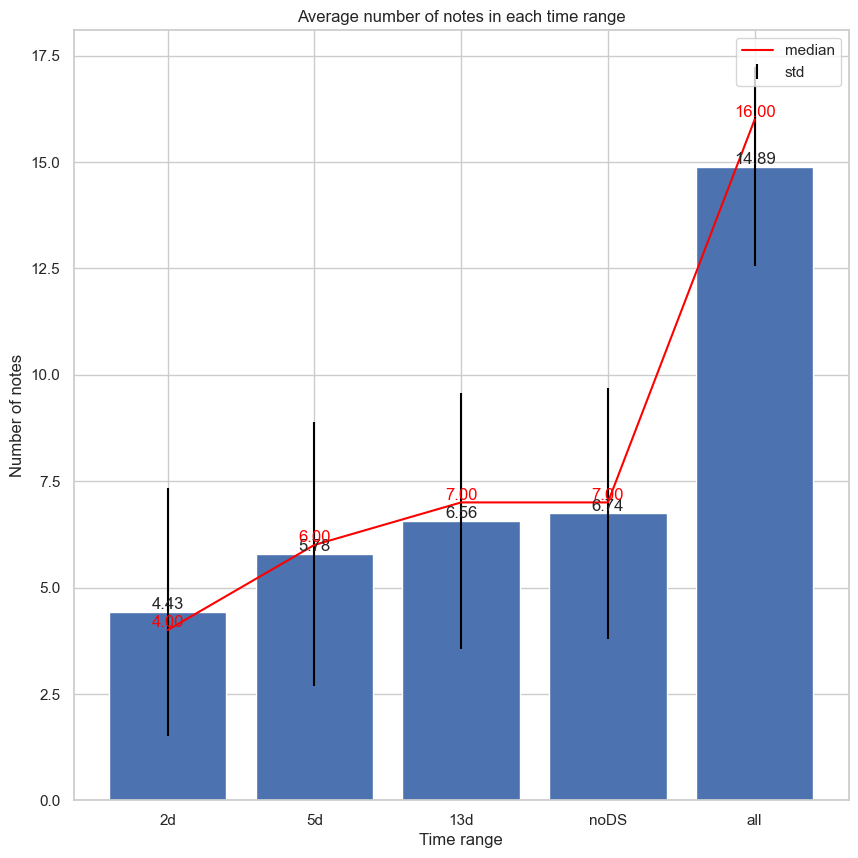

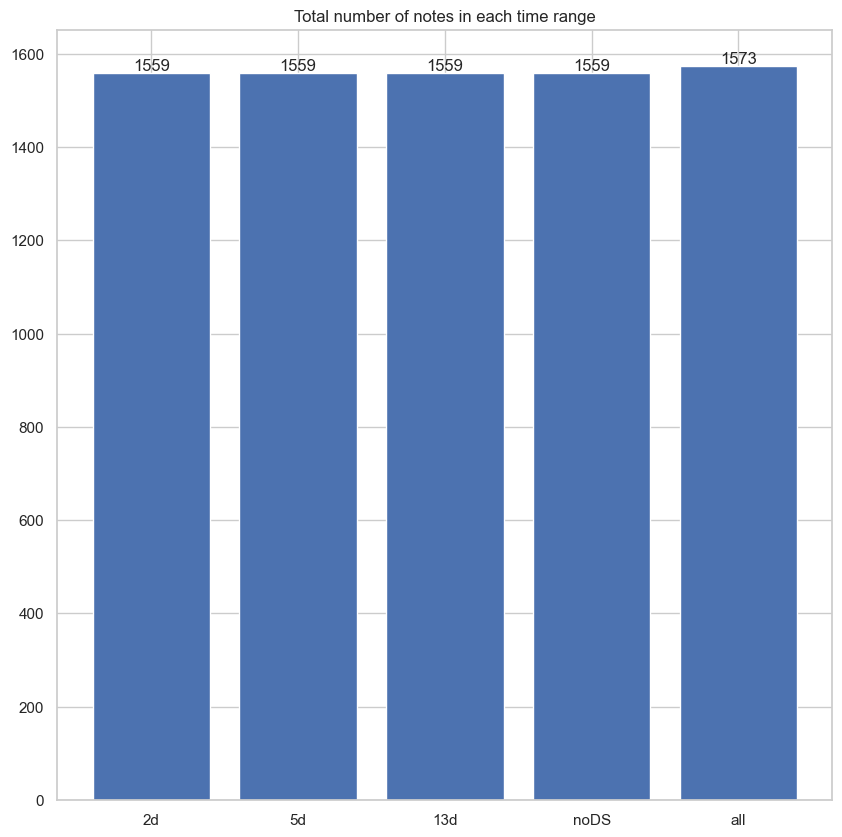

In [5]:
plot_temporal_dist(notes_length_uniform, num_samples_uniform)

### 2) uniform (limited) setup

In [11]:
notes_length_uniform_l, num_samples_uniform_l = get_temporal_dist(validation_set_uniform_l)

In [12]:
print_latex_string(notes_length_uniform_l)

& 5.7\textsubscript {$\pm$3.6}& 7.9\textsubscript {$\pm$3.7}& 9.4\textsubscript {$\pm$3.5}& 9.9\textsubscript {$\pm$3.3}& 13.8\textsubscript {$\pm$3.4}


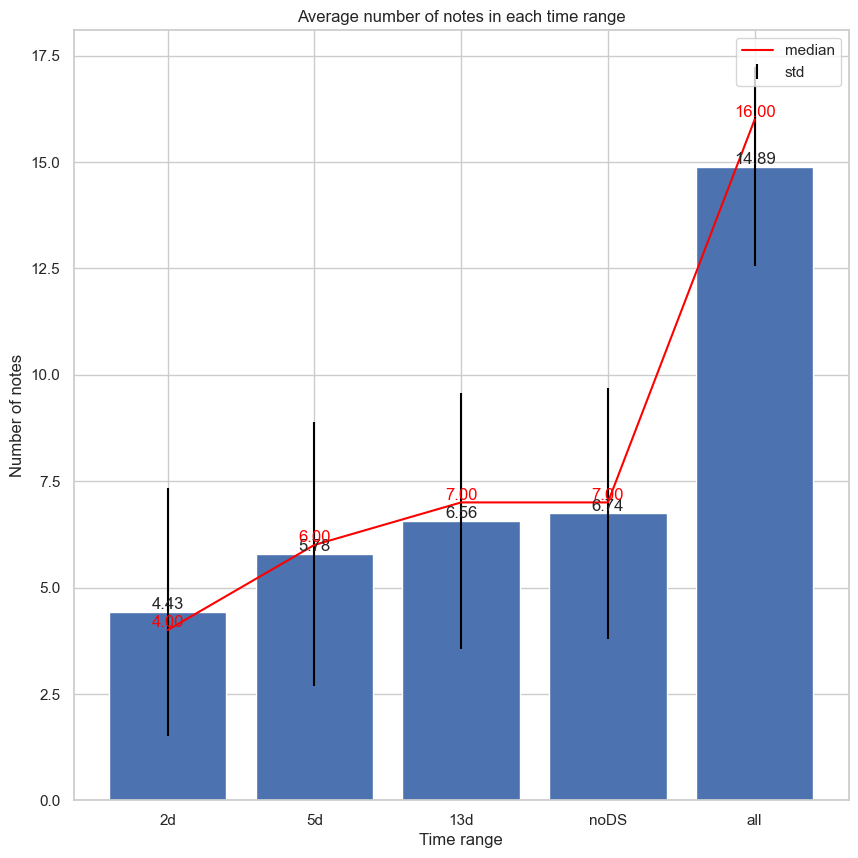

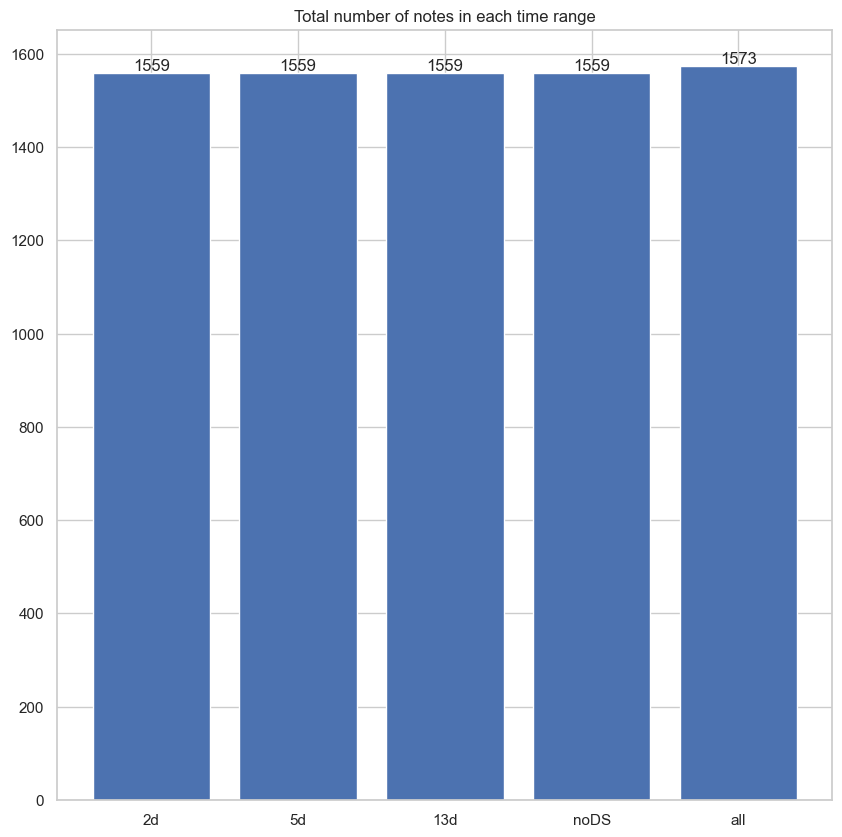

In [7]:
plot_temporal_dist(notes_length_uniform_l, num_samples_uniform_l)

### 3) latest set-up

In [13]:
notes_length_latest, num_samples_latest = get_temporal_dist(validation_set_latest)

In [15]:
print_latex_string(notes_length_latest)

& 5.0\textsubscript {$\pm$3.0}& 6.3\textsubscript {$\pm$3.0}& 6.8\textsubscript {$\pm$2.9}& 6.9\textsubscript {$\pm$2.9}& 14.8\textsubscript {$\pm$2.5}


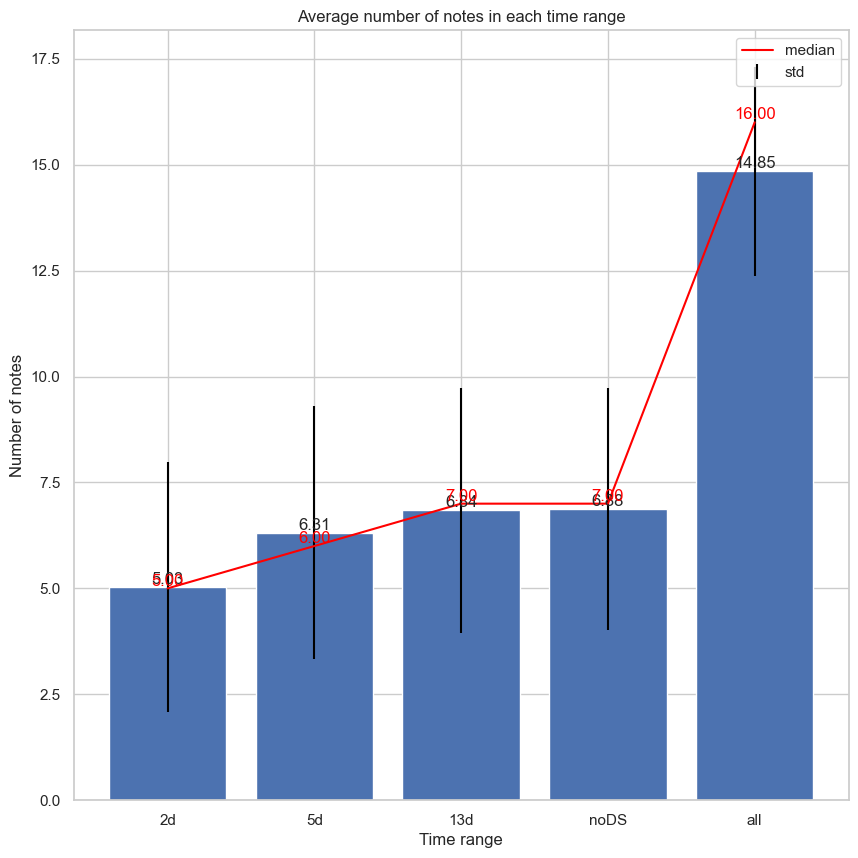

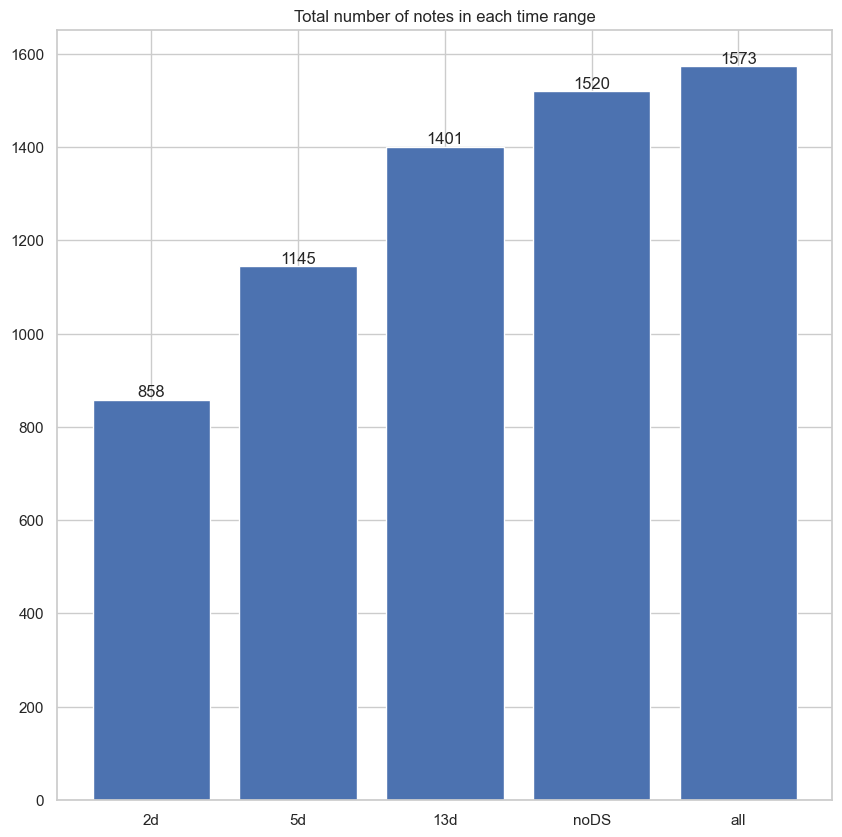

In [16]:
plot_temporal_dist(notes_length_latest, num_samples_latest)

### 4) random set-up

In [6]:
notes_length_random, num_samples_random = get_temporal_dist(validation_set_random)

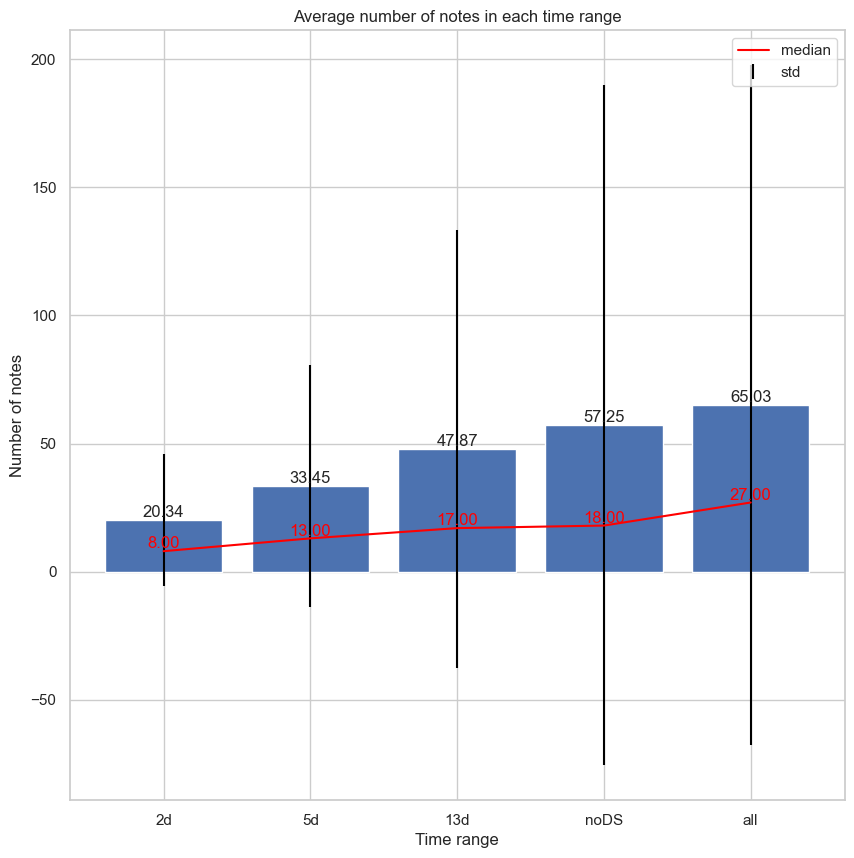

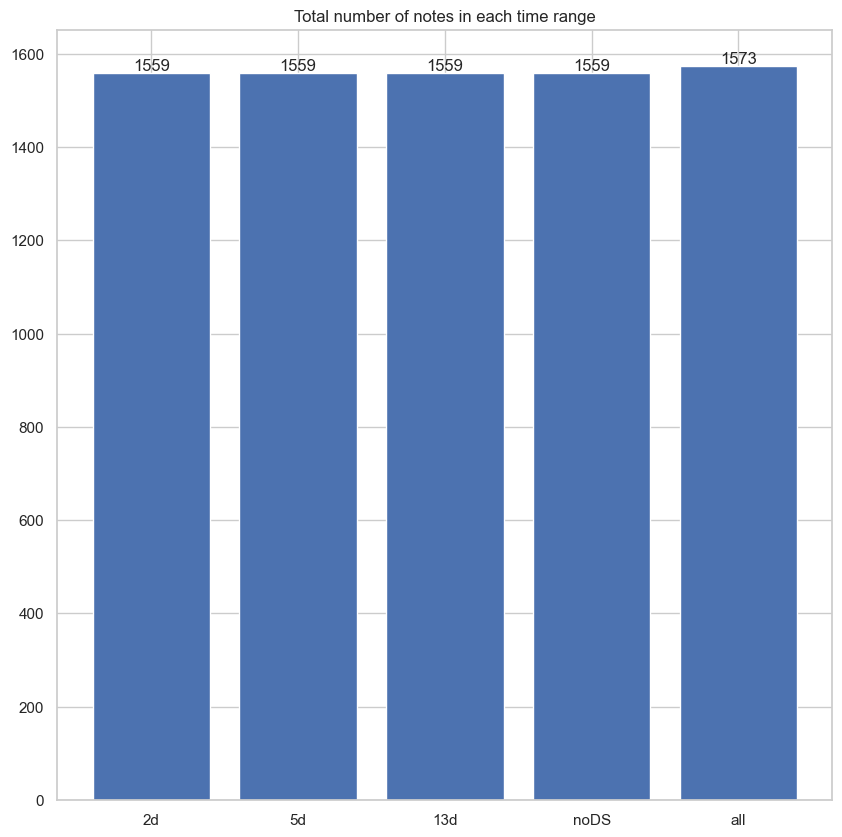

In [8]:
plot_temporal_dist(notes_length_random, num_samples_random)

In [7]:
print_latex_string(notes_length_random)

& 17.9\textsubscript {$\pm$22.1}& 27.6\textsubscript {$\pm$33.9}& 35.8\textsubscript {$\pm$42.4}& 40.4\textsubscript {$\pm$47.7}& 48.4\textsubscript {$\pm$48.1}


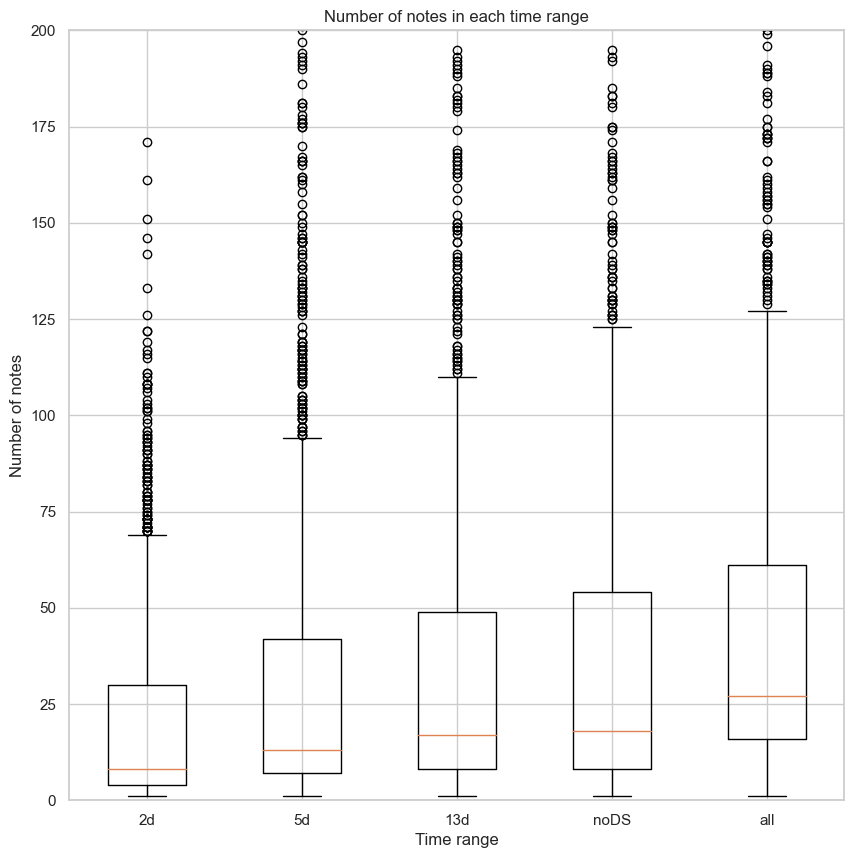

In [24]:
plot_temporal_dist_boxplots(notes_length_random, num_samples_random)

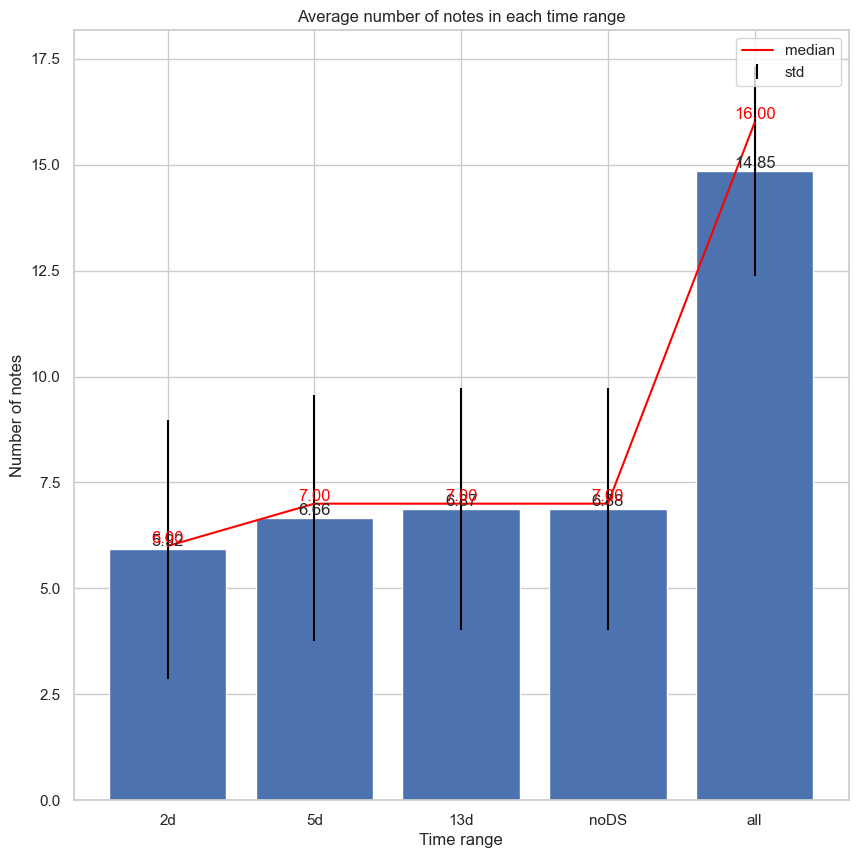

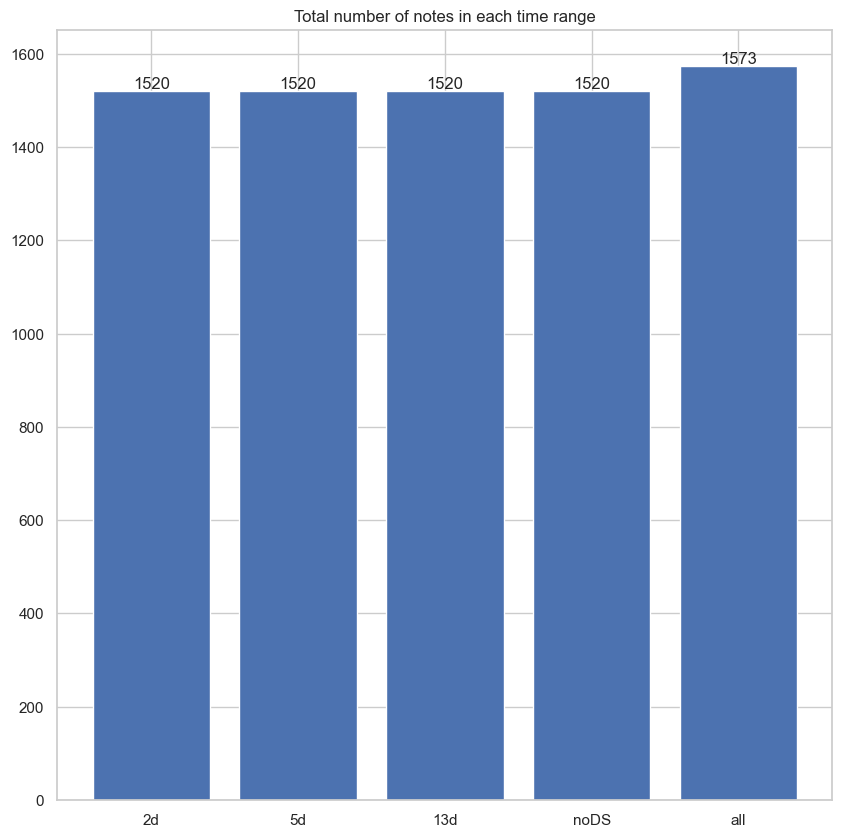

In [43]:
notes_length_latest, num_samples_latest = get_temporal_dist(validation_set_latest)
plot_temporal_dist(notes_length_latest, num_samples_latest)

#### Analyze sections of DS

#### Analyze number of notes in each time range

In [ ]:
def get_cutoffs(hours_elapsed, category_ids):
    cutoffs = {'2d': -1, '5d': -1, '13d': -1, 'noDS': -1, 'all': -1}
    for i, (hour, cat) in enumerate(zip(hours_elapsed, category_ids)):
        if cat != 5:
            if hour < 2*24:
                cutoffs['2d'] = i
            if hour < 5*24:
                cutoffs['5d'] = i
            if hour < 13*24:
                cutoffs['13d'] = i
            cutoffs['noDS'] = i
        cutoffs['all'] = i
    return cutoffs

In [ ]:
# TODO: run this cell for the meeting - get the number of chunks in each time range for the validation set
# Get number of chunks in each time range for the validation set
cutoffs_stats = {'2d': [], '5d': [], '13d': [], 'noDS': [], 'all': []}

for i in range(len(validation_set)):
    sample = validation_set[i]
    cutoffs = get_cutoffs(sample['hours_elapsed'], sample['category_ids']) 
    for time_range in cutoffs_stats.keys():
        cutoffs_stats[time_range].append(cutoffs[time_range])

# Plot the average number of chunks for each time range
import matplotlib.pyplot as plt
plt.bar(cutoffs_stats.keys(), [np.mean(cutoffs_stats[time_range]) for time_range in cutoffs_stats.keys()])
plt.show()

In [24]:
def get_cutoffs(hours_elapsed, category_ids):
    cutoffs = {'2d': -1, '5d': -1, '13d': -1, 'noDS': -1, 'all': -1}
    for i, (hour, cat) in enumerate(zip(hours_elapsed, category_ids)):
        if cat != 5:
            if hour < 2*24:
                cutoffs['2d'] = i
            if hour < 5*24:
                cutoffs['5d'] = i
            if hour < 13*24:
                cutoffs['13d'] = i
            cutoffs['noDS'] = i
        cutoffs['all'] = i
    return cutoffs

In [25]:
from tqdm import tqdm
notes_length = {'2d': [], '5d': [], '13d': [], 'noDS': [], 'all': []}
num_samples = {'2d': [], '5d': [], '13d': [], 'noDS': [], 'all': []}

for i in range(len(training_set)):
    sample = training_set[i]
    cutoffs = get_cutoffs(sample['hours_elapsed'], sample['category_ids'])
    for time_range in cutoffs.keys():
        if cutoffs != -1:
            notes_length[time_range].append(cutoffs[time_range])
            num_samples[time_range].append(1)


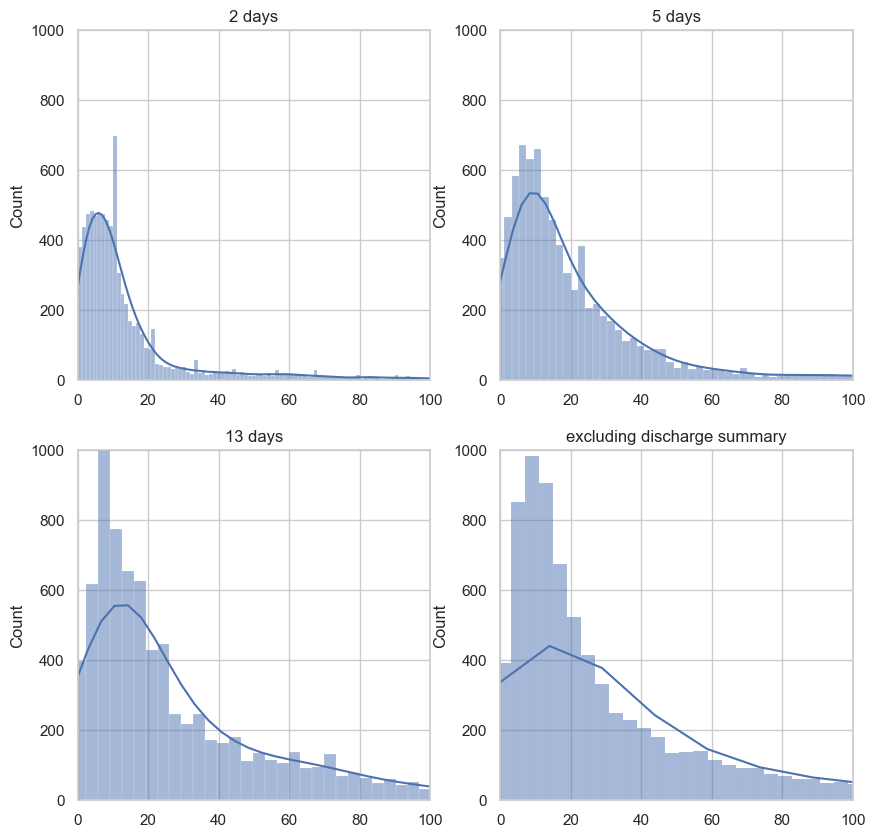

In [43]:
# plot the distribution of notes length for each time range
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
sns.histplot(notes_length['2d'], ax=axs[0, 0], kde=True)
axs[0, 0].set_title('2 days')
# limit x-axis range from 0 to 1000
axs[0, 0].set_xlim([0, 100])
axs[0,0].set_ylim([0, 1000])
sns.histplot(notes_length['5d'], ax=axs[0, 1], kde=True)
axs[0, 1].set_title('5 days')
axs[0, 1].set_xlim([0, 100])
axs[0,1].set_ylim([0, 1000])

sns.histplot(notes_length['13d'], ax=axs[1, 0], kde=True)
axs[1, 0].set_title('13 days')
axs[1, 0].set_xlim([0, 100])
axs[1,0].set_ylim([0, 1000])

sns.histplot(notes_length['noDS'], ax=axs[1, 1], kde=True)
axs[1, 1].set_title('excluding discharge summary')
axs[1, 1].set_xlim([0, 100])
axs[1,1].set_ylim([0, 1000])

plt.show()


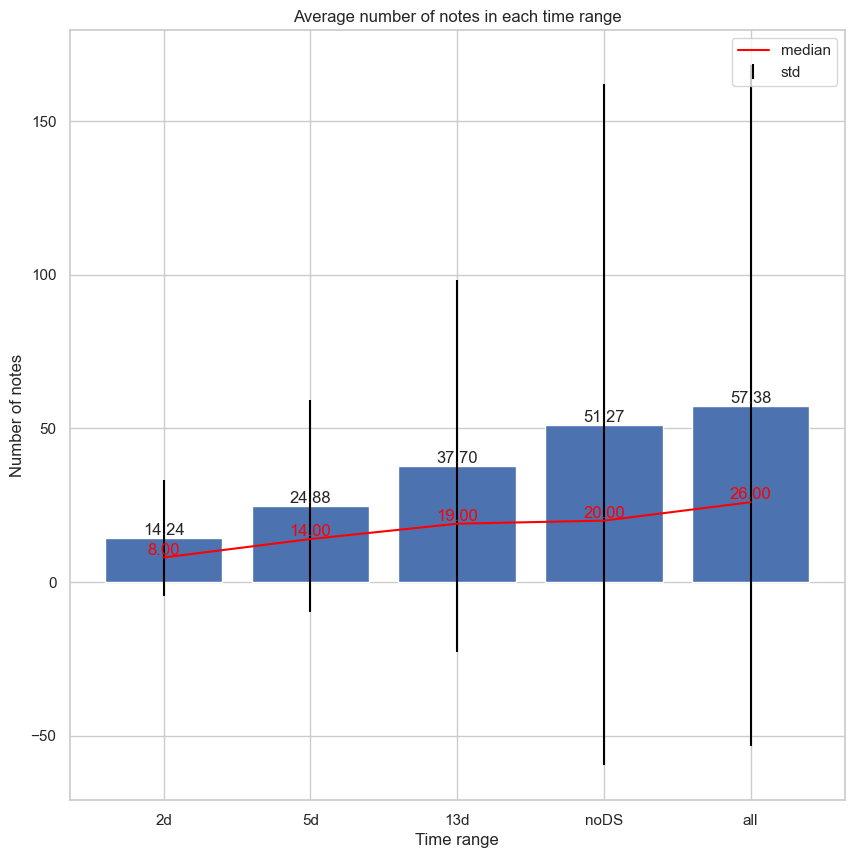

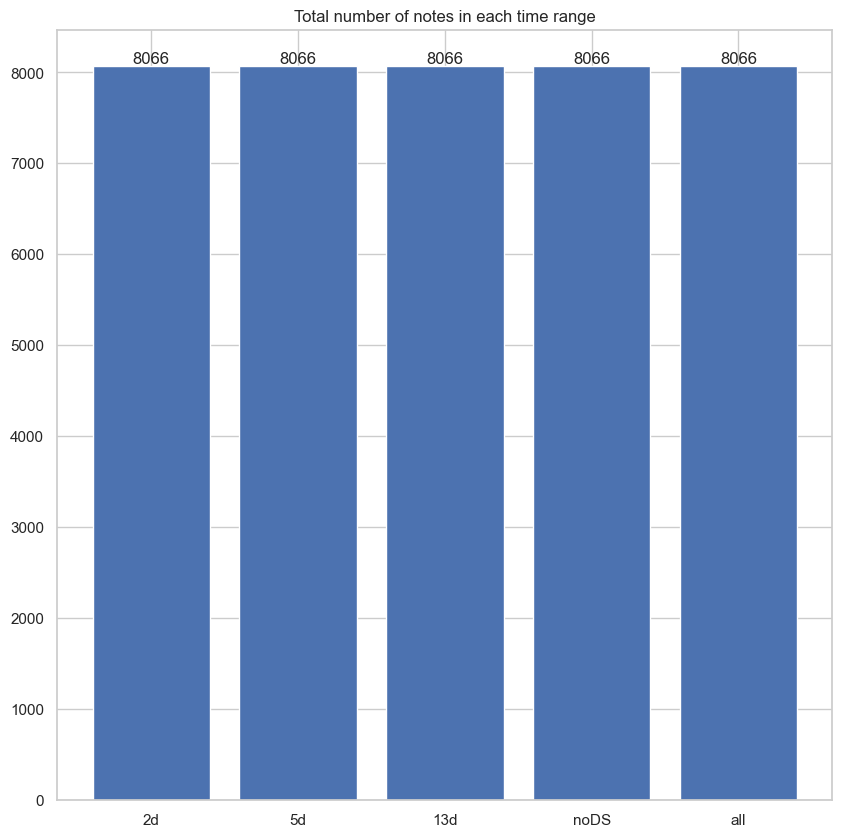

In [57]:
# print bar plot with the average number of notes and number of samples in each time range
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 10))
plt.bar(notes_length.keys(), [np.mean(notes_length[key]) for key in notes_length.keys()])
# show the standard deviation on the bar plot
# show the average number of notes in each time range on top of the bar plot as a number
for i, time_range in enumerate(notes_length.keys()):
    plt.text(i, np.mean(notes_length[time_range]), f"{np.mean(notes_length[time_range]):.2f}", ha='center', va='bottom')
plt.errorbar(notes_length.keys(), [np.mean(notes_length[key]) for key in notes_length.keys()], yerr=[np.std(notes_length[key]) for key in notes_length.keys()], fmt='none', c='black', label='std')
# show the median number of notes in each time range as a line on the bar plot
plt.plot(notes_length.keys(), [np.median(notes_length[key]) for key in notes_length.keys()], c='red', label='median')
# show median number of notes on top of the bar plot as a number
for i, time_range in enumerate(notes_length.keys()):
    plt.text(i, np.median(notes_length[time_range]), f"{np.median(notes_length[time_range]):.2f}", ha='center', va='bottom', c='red')
# add another bar plot with the number of samples
# the bar plot needs to be separated from the previous one
# otherwise the y-axis will be shared and the number of samples will be too small to be seen
plt.title('Average number of notes in each time range')
plt.xlabel('Time range')
plt.ylabel('Number of notes')
plt.legend()
plt.figure(figsize=(10, 10))

plt.bar(notes_length.keys(), [np.sum(num_samples[key]) for key in notes_length.keys()])
# show number of samples on top of the bar plot as a number
for i, time_range in enumerate(notes_length.keys()):
    plt.text(i, np.sum(num_samples[time_range]), f"{np.sum(num_samples[time_range]):.0f}", ha='center', va='bottom')
plt.title('Total number of notes in each time range')
plt.show()


Average total duration: 11.35 days
Std total duration: 12.98 days
Min total duration: 0.00 days
Max total duration: 192.00 days


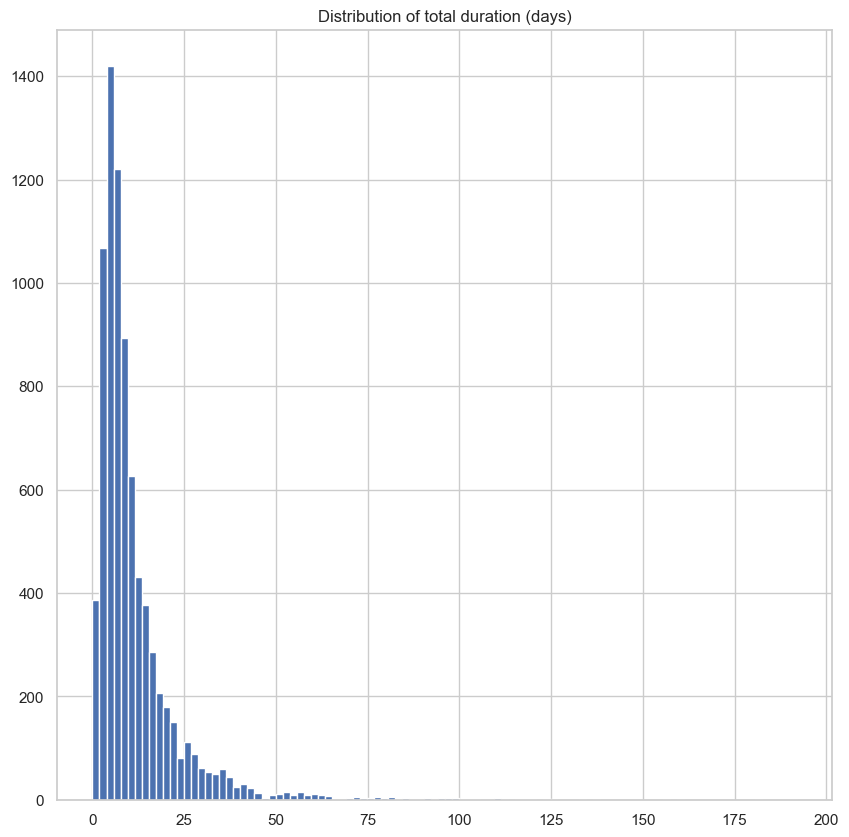

In [41]:
# show the shortest and longest stay
# by looking at hours_elapsed[-1]
# and the number of notes in each time range
total_duration = []
for i in range(len(training_set)):
    sample = training_set[i]
    total_duration.append(sample['hours_elapsed'][-1])
# show the average, std, min, max of the total duration
# in days
print(f"Average total duration: {np.mean(total_duration)/24:.2f} days")
print(f"Std total duration: {np.std(total_duration)/24:.2f} days")
print(f"Min total duration: {np.min(total_duration)/24:.2f} days")
print(f"Max total duration: {np.max(total_duration)/24:.2f} days")

# plot the distribution of total duration
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.hist([d/24 for d in total_duration], bins=100)
plt.title('Distribution of total duration (days)')
plt.show()


25% percentile: 1.84
50% percentile: 5.68
75% percentile: 13.74


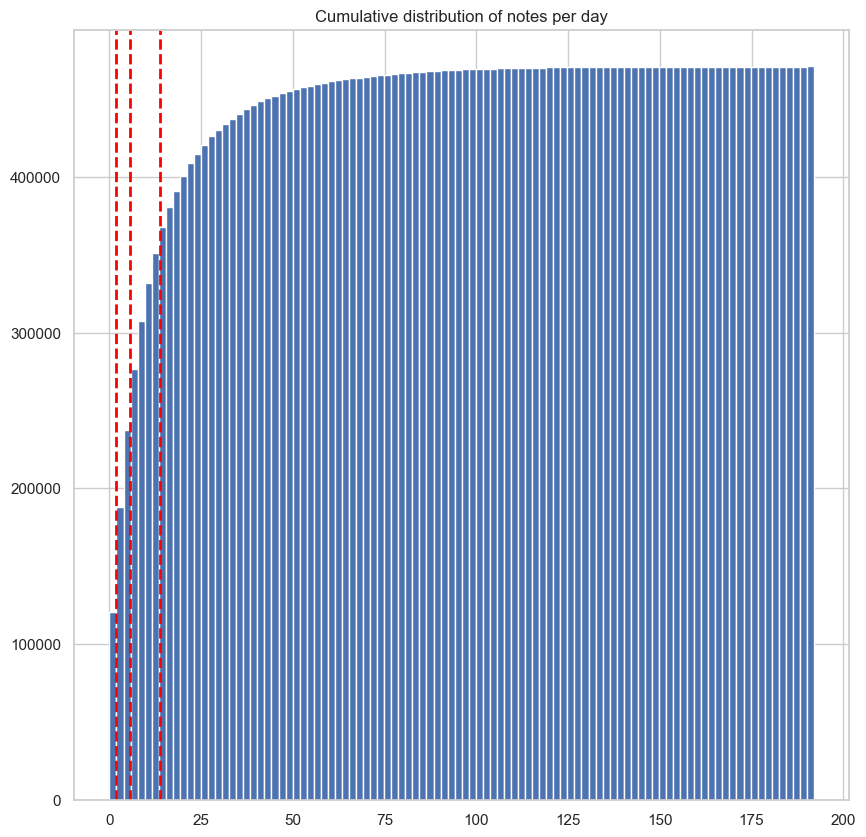

In [52]:
# show the numbr of notes under each time range
# in days
# show the shortest and longest stay
# by looking at hours_elapsed[-1]
# and the number of notes in each time range
notes_per_day = []
for i in range(len(training_set)):
    sample = training_set[i]
    notes_per_day.extend(sample['hours_elapsed']/24)

# show cumulative distribution of notes per day
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.hist(notes_per_day, bins=100, cumulative=True)
plt.title('Cumulative distribution of notes per day')

# show 25%, 50%, 75% percentile in the plot
plt.axvline(np.percentile(notes_per_day, 25), color='red', linestyle='dashed', linewidth=2)
plt.axvline(np.percentile(notes_per_day, 50), color='red', linestyle='dashed', linewidth=2)
plt.axvline(np.percentile(notes_per_day, 75), color='red', linestyle='dashed', linewidth=2)
# print the percentile as a number
print(f"25% percentile: {np.percentile(notes_per_day, 25):.2f}")
print(f"50% percentile: {np.percentile(notes_per_day, 50):.2f}")
print(f"75% percentile: {np.percentile(notes_per_day, 75):.2f}")
plt.show()


In [ ]:
from tqdm import tqdm
notes_length = {'2d': [], '5d': [], '13d': [], 'noDS': [], 'all': []}
num_samples = {'2d': [], '5d': [], '13d': [], 'noDS': [], 'all': []}

num_chunks = 
for i in tqdm(range(len(training_set))):
    sample = training_set[i]
    hours_elapsed = sample["hours_elapsed"]
    seq_ids = sample["seq_ids"]
    for time_range in sample["cutoffs"].keys():
        if sample["cutoffs"][time_range] != -1:
            notes_length[time_range].append(sample['cutoffs'][time_range])
            num_samples[time_range].append(1)


# Analyze fourth setup: random sampling during training, use all for evaluation